## Assignment: wt(IDF-w2v)+wb(brand)+wc(color)+wi(image-VGG16)

In [1]:
#import all the necessary packages.

import PIL.Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
##Input preprocessed data from pickels
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [3]:
## Utility Functions 

#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))## if problem then use: img = PIL.Image.open(BytesIO(response.content)).convert('RGBA')
    # we will display it in notebook 
    plt.imshow(img)

In [4]:
# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns a sparse matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc
from sklearn.feature_extraction.text import CountVectorizer
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])
idf_title_features.get_shape() # get number of rows and columns in feature matrix.


(16042, 12609)

In [5]:
##function for idf
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [6]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [7]:
import pickle

# in this project we are using a pretrained model by google
with open('word2vec_model', 'rb') as handle: ##this model is a dictionary of our 12k words and their corresponding vectors(sampled from google news vectors)
    model = pickle.load(handle)

In [8]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


In [9]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [10]:
##IDF weighted Word2Vec for product similarity
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [11]:
##Weighted similarity using brand and color
##one hot encoding for brand and color then concatenation
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
#types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

#type_vectorizer = CountVectorizer()
#type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

#extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [12]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [13]:
## Visual features based product similarity
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
import PIL.Image
import pandas as pd
import pickle

Using TensorFlow backend.


In [14]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
#data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

from IPython.display import display, Image, SVG, Math, YouTubeVideo

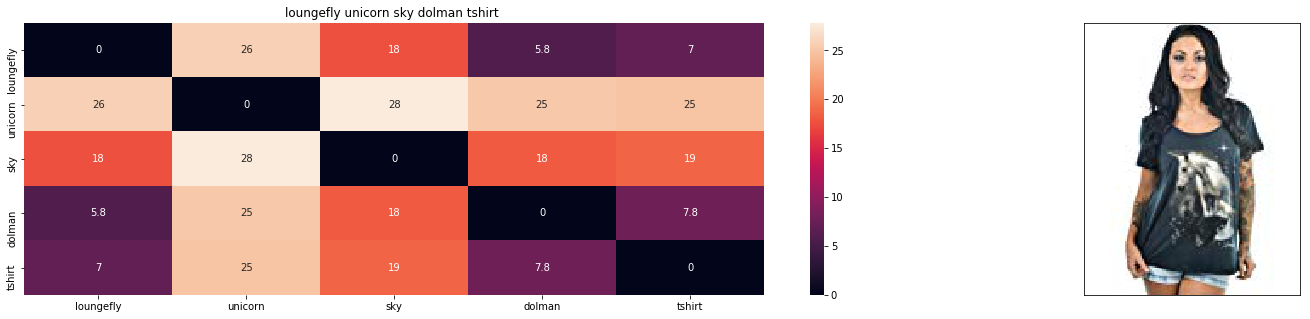

ASIN : B00H0G0DMM
Brand : Loungefly
euclidean distance from input : 0.0


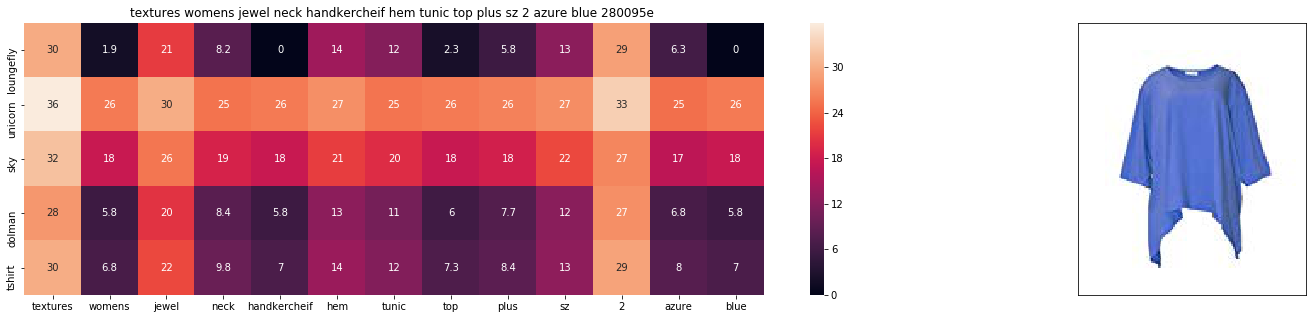

ASIN : B073T2SP79
Brand : Textures
euclidean distance from input : 10.529269548257327


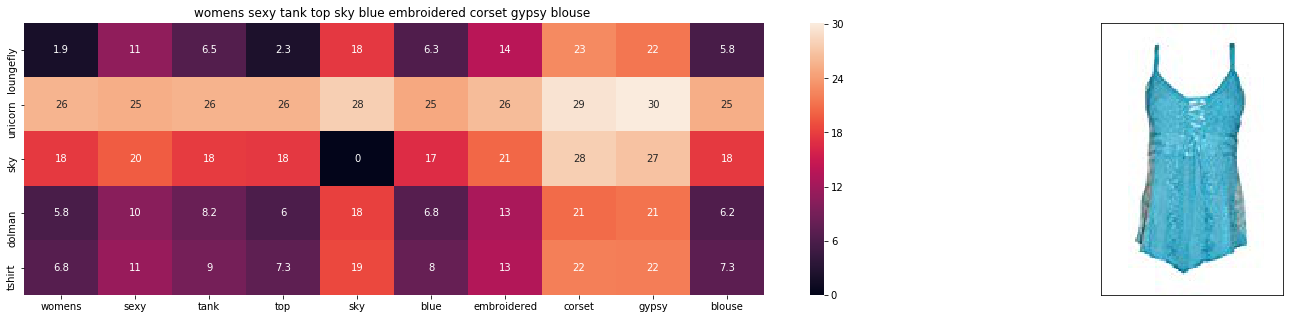

ASIN : B01MSQTMUB
Brand : Mogul Interior
euclidean distance from input : 10.628887244447428


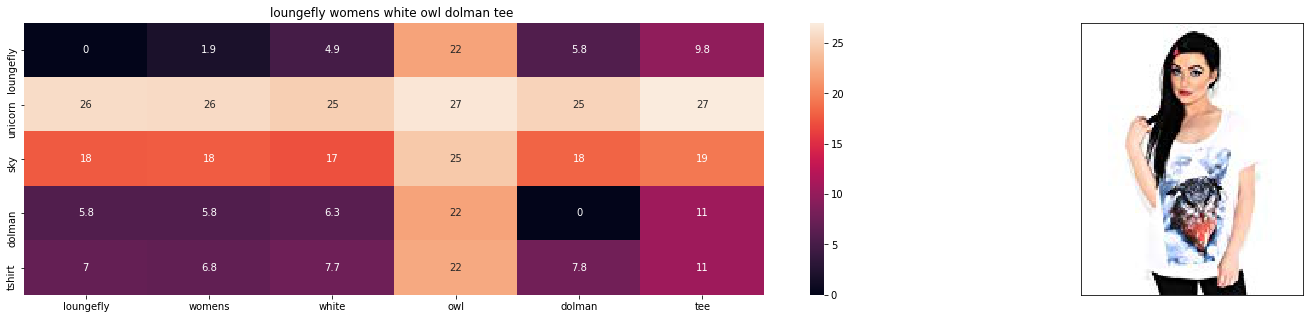

ASIN : B00XWTZ82Q
Brand : Loungefly
euclidean distance from input : 10.676646007191051


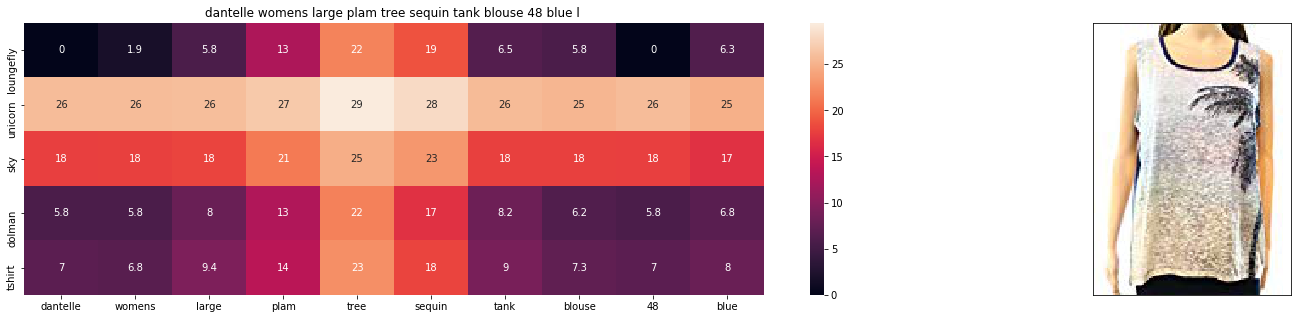

ASIN : B074P85Y4R
Brand : Dantelle
euclidean distance from input : 10.706233493125936


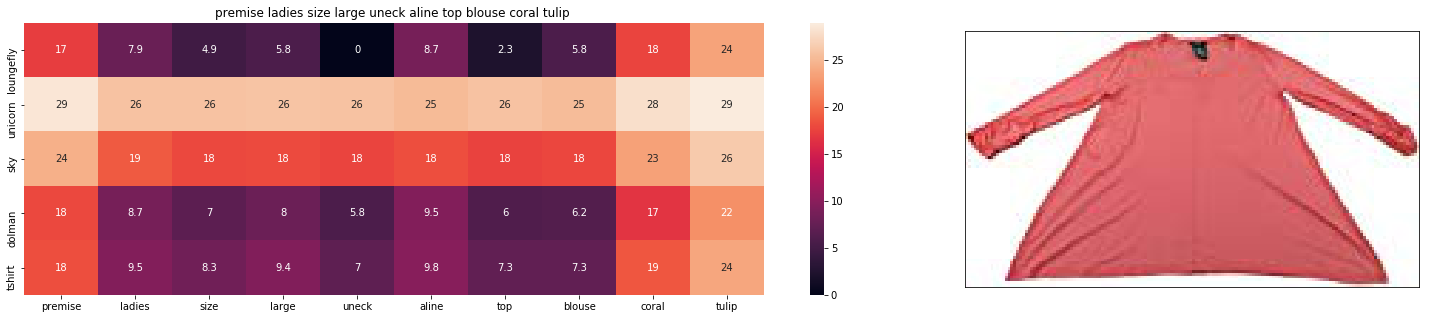

ASIN : B01CRH2D1W
Brand : Premise
euclidean distance from input : 10.719662614663577


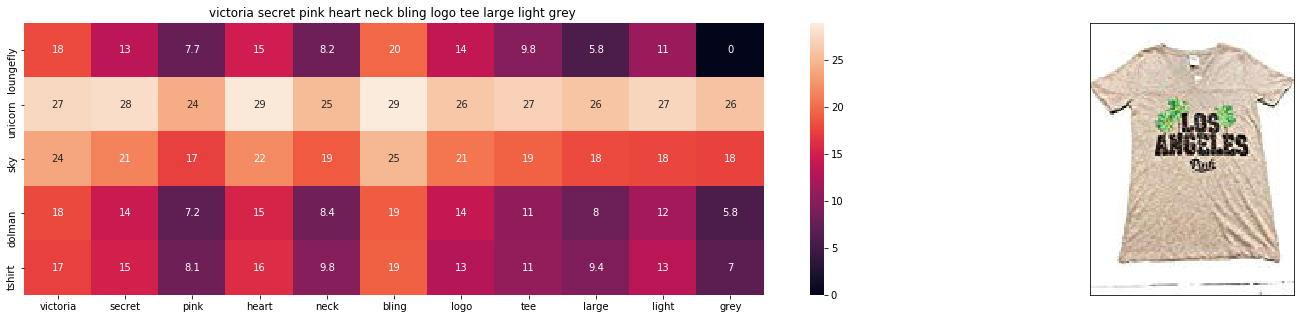

ASIN : B01N1PFHSN
Brand : V.Secret
euclidean distance from input : 10.72881206201798


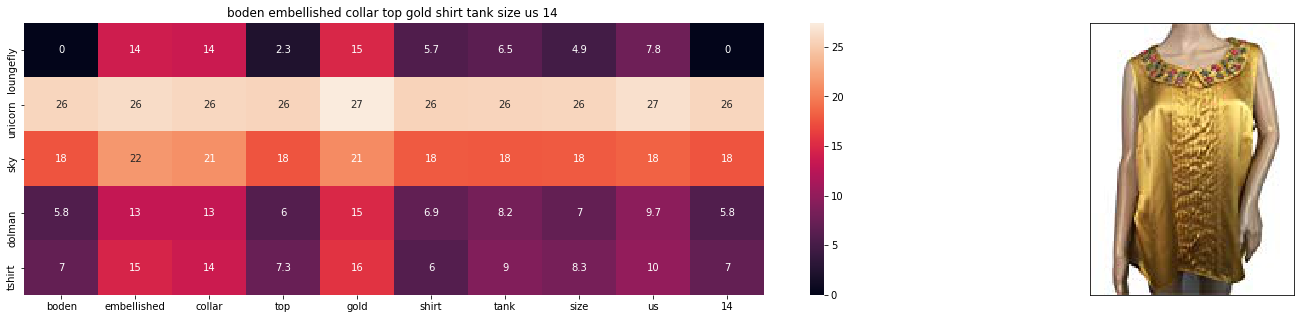

ASIN : B072HCVT7P
Brand : BODEN
euclidean distance from input : 10.738845686840424


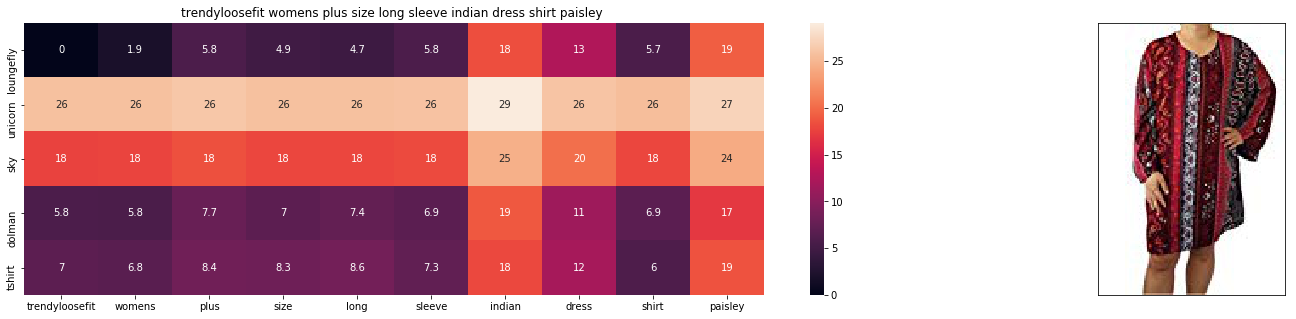

ASIN : B019RX91LY
Brand : Trendyloosefit
euclidean distance from input : 10.748391030412867


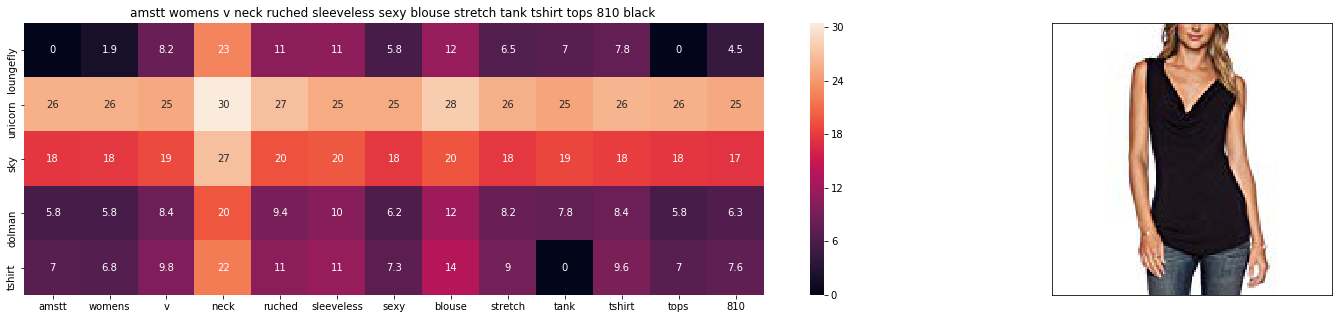

ASIN : B01LWN9Z5K
Brand : Amstt
euclidean distance from input : 10.750545016563436


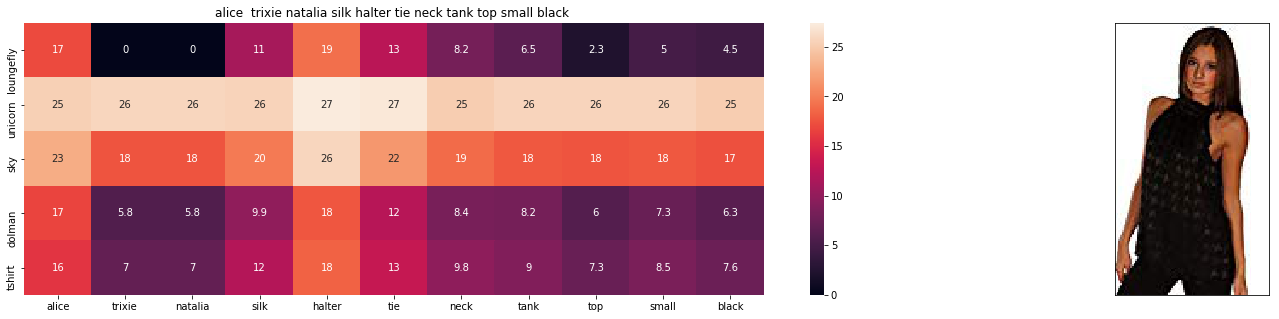

ASIN : B01D7T4BIC
Brand : Alice & Trixie
euclidean distance from input : 10.775996952366462


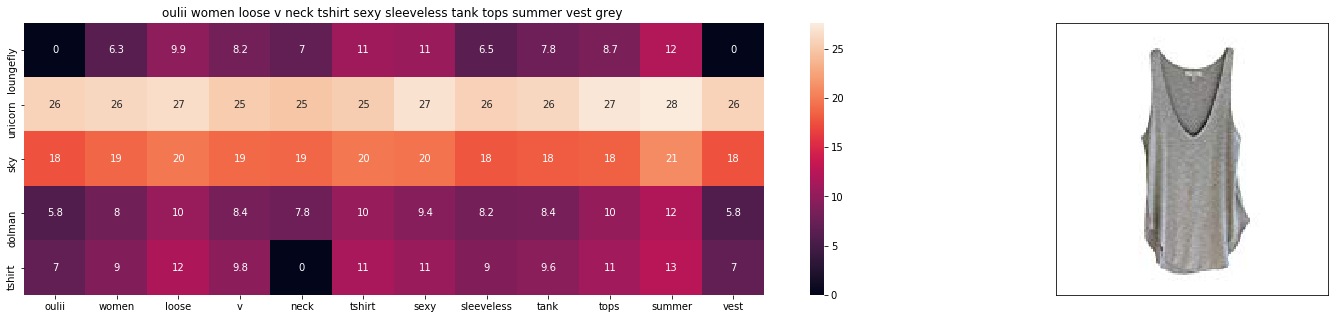

ASIN : B072KH8HBJ
Brand : OULII
euclidean distance from input : 10.783583624074089


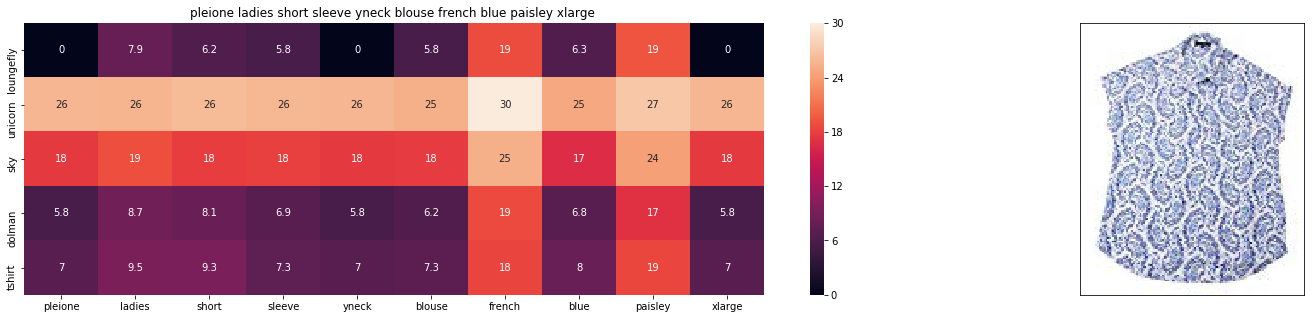

ASIN : B073X6Q3RK
Brand : Pleione
euclidean distance from input : 10.79333842920548


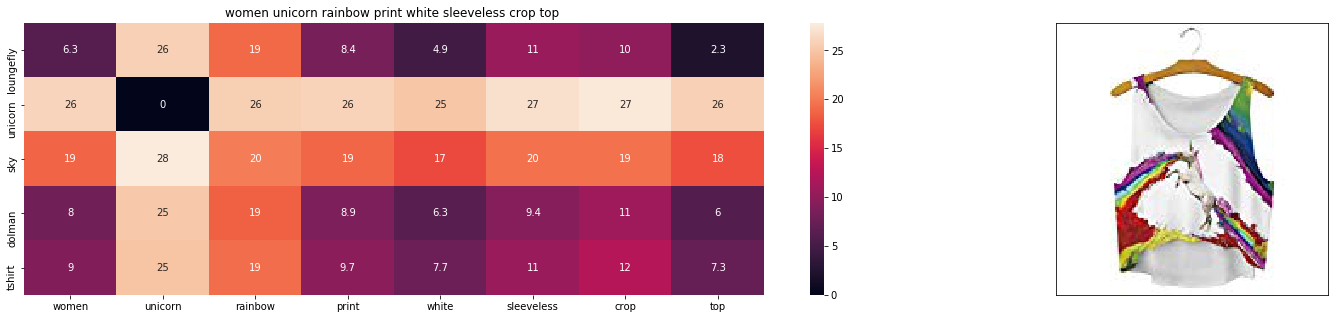

ASIN : B074V1975B
Brand : MKP Crop Top
euclidean distance from input : 10.84671436656605


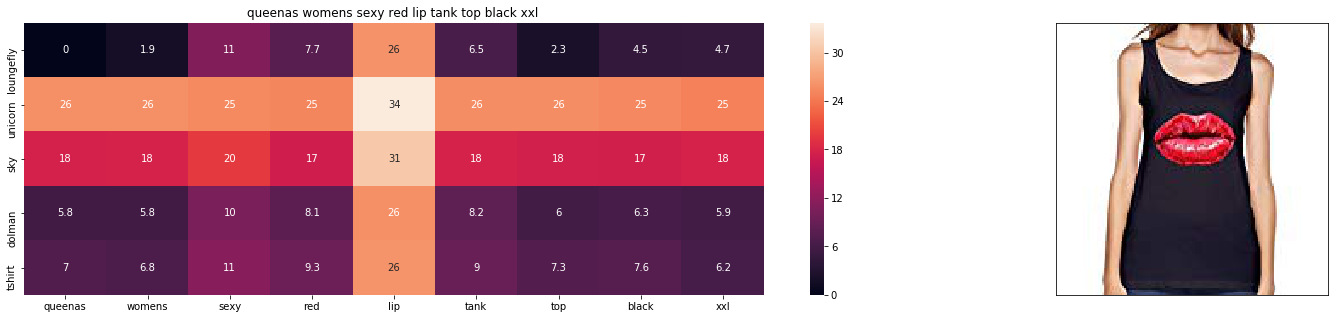

ASIN : B01D77TDV4
Brand : QUEENAS
euclidean distance from input : 10.84715590079639


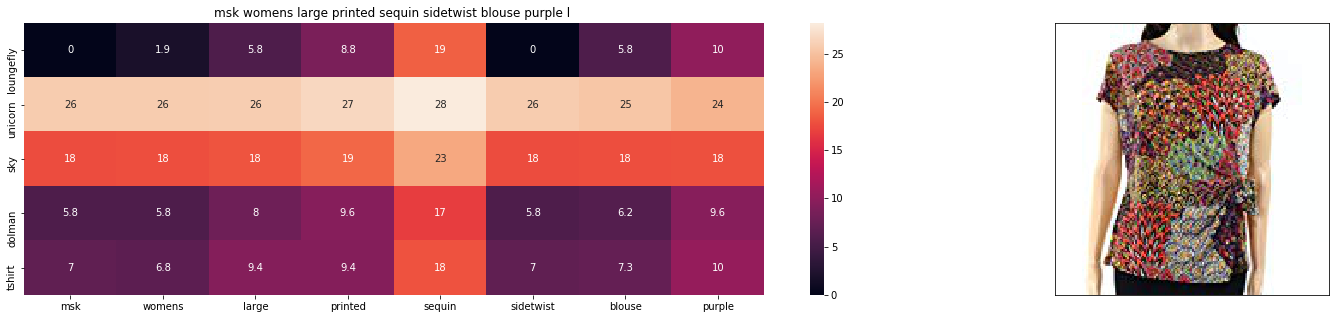

ASIN : B074MHQ1T6
Brand : MSK
euclidean distance from input : 10.848422935153634


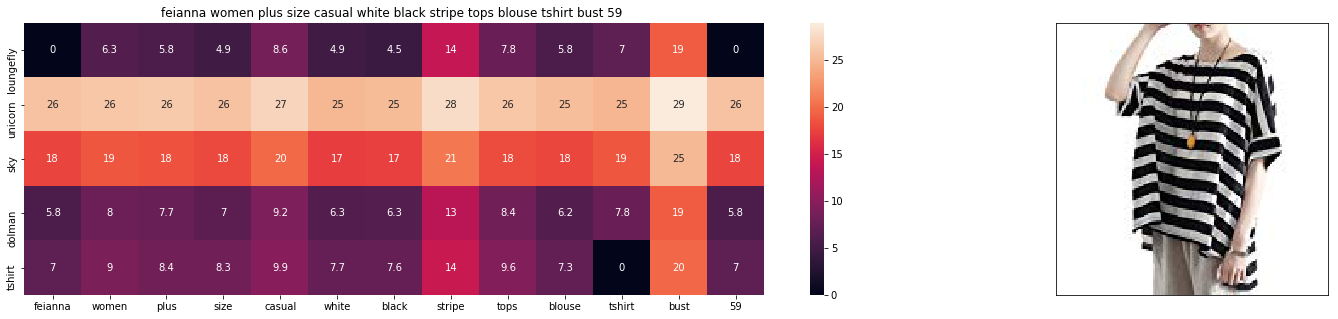

ASIN : B072WQ86QJ
Brand : FEIANNA
euclidean distance from input : 10.854877957792128


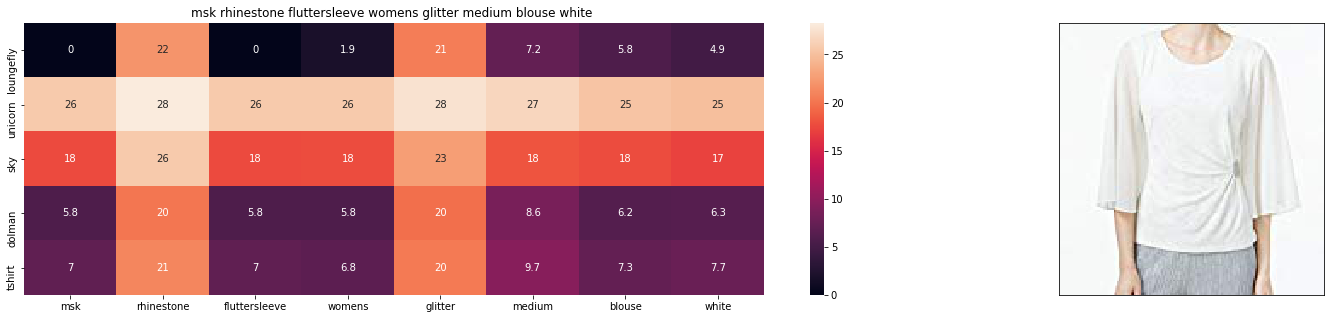

ASIN : B074MHV9GX
Brand : MSK
euclidean distance from input : 10.901562639077639


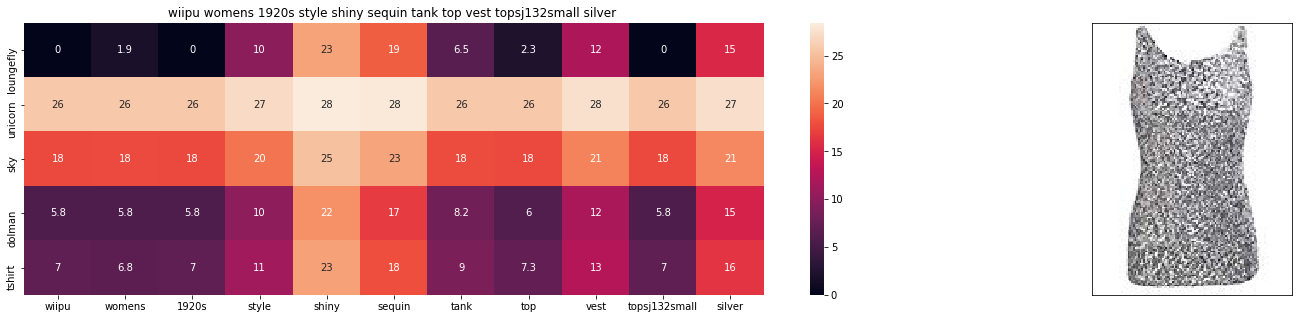

ASIN : B01NCV1TKU
Brand : WIIPU
euclidean distance from input : 10.921671503601788


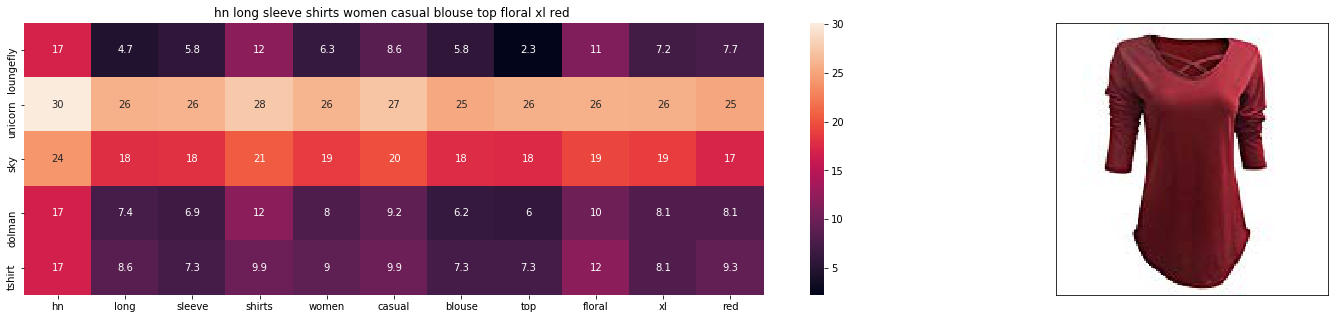

ASIN : B0711KH9DX
Brand : H&N
euclidean distance from input : 10.956116832386364


In [36]:
def idf_w2v_brand(doc_id, w1, w2, w3, w4, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand features
    # w3: weight for color features
    # w4: weight for image features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    doc_id = asins.index(df_asins[doc_id])
    image_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_feat_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_feat_dist = pairwise_distances(color_features, color_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * brand_feat_dist +  w3 * brand_feat_dist+  w4 * image_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distance's
    df_indices = list(data.index[indices]) 
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(1269, 50, 5, 50, 5, 20)# change accordingly
# in the give heat map, each cell contains the euclidean distance between words i, j

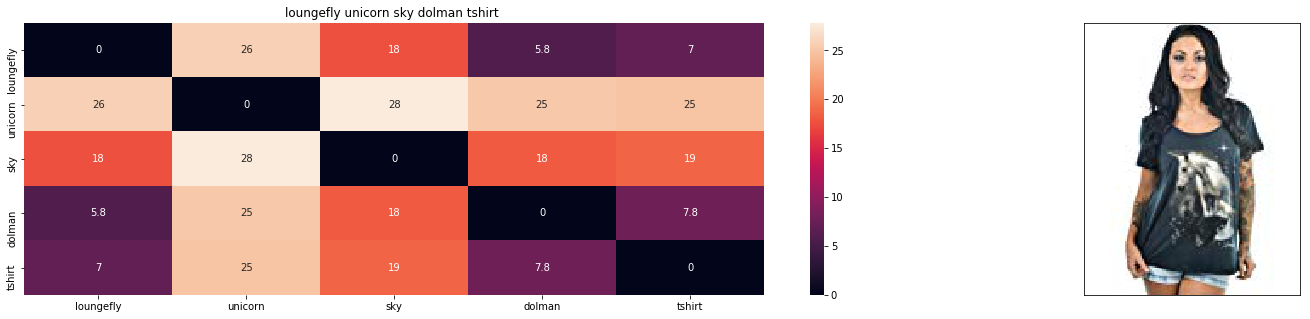

ASIN : B00H0G0DMM
Brand : Loungefly
euclidean distance from input : 0.0


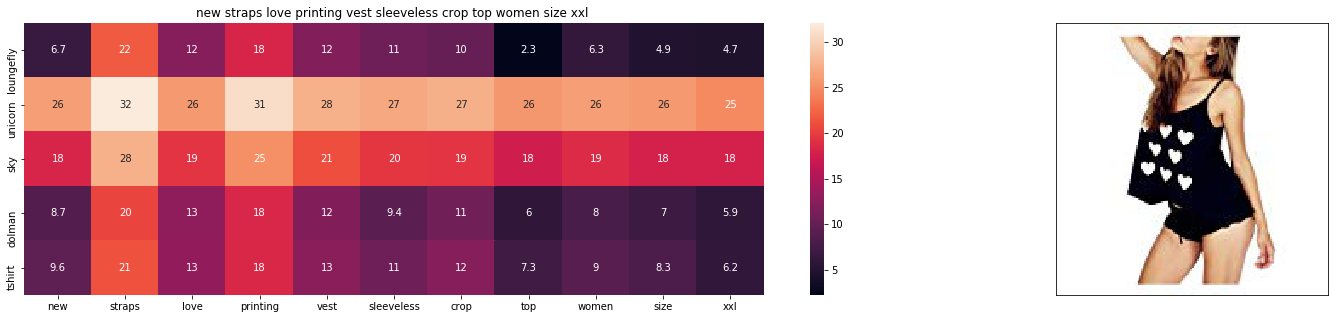

ASIN : B00KDW8B1A
Brand : namnoishop Crop Tops
euclidean distance from input : 21.02340431213379


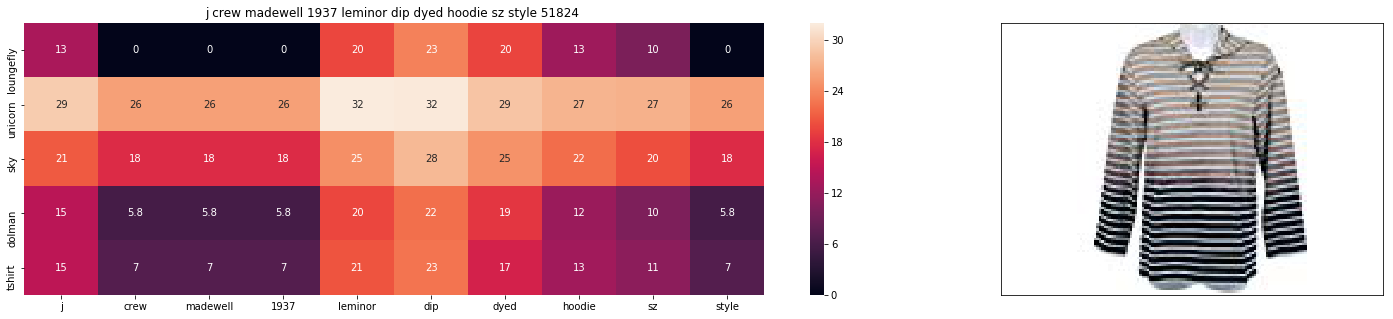

ASIN : B01GTF5X42
Brand : Madewell
euclidean distance from input : 21.35766143834966


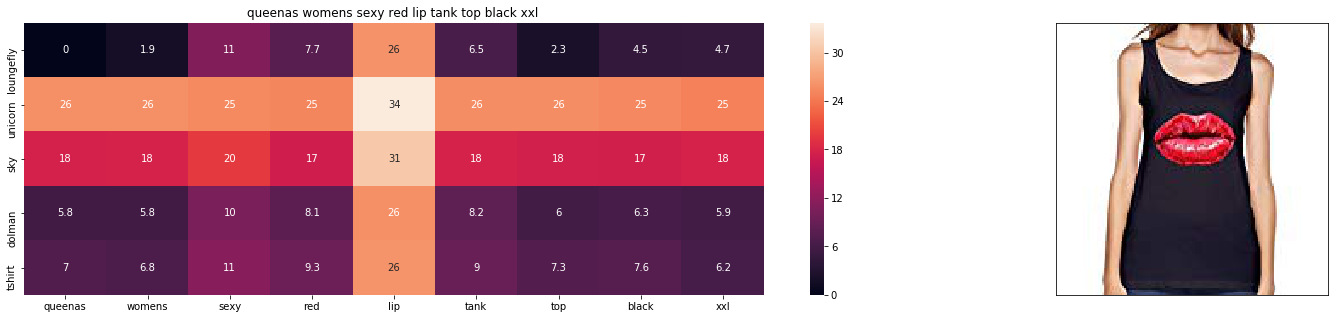

ASIN : B01D77TDV4
Brand : QUEENAS
euclidean distance from input : 21.56040992772954


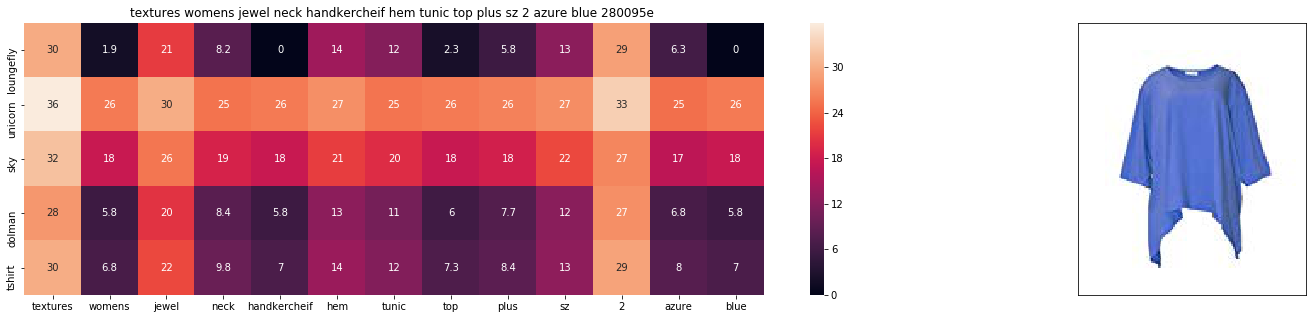

ASIN : B073T2SP79
Brand : Textures
euclidean distance from input : 21.695937347773487


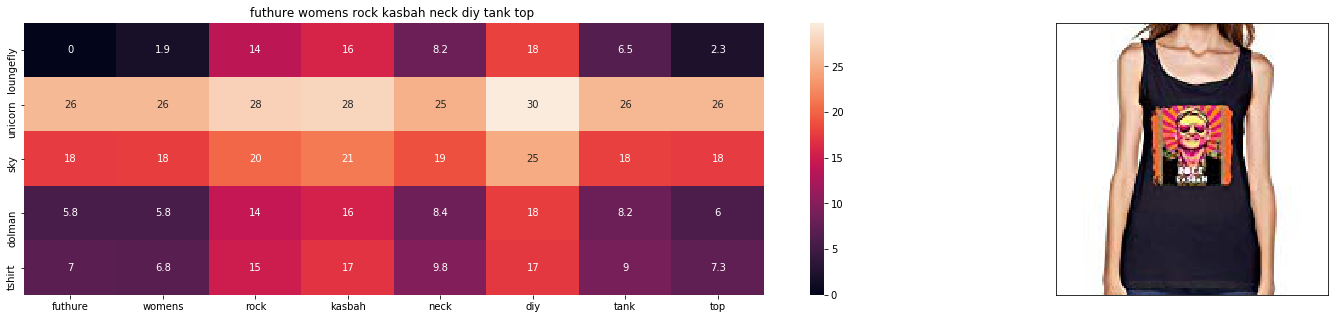

ASIN : B01KHDMUI4
Brand : Futhure
euclidean distance from input : 21.748687744502


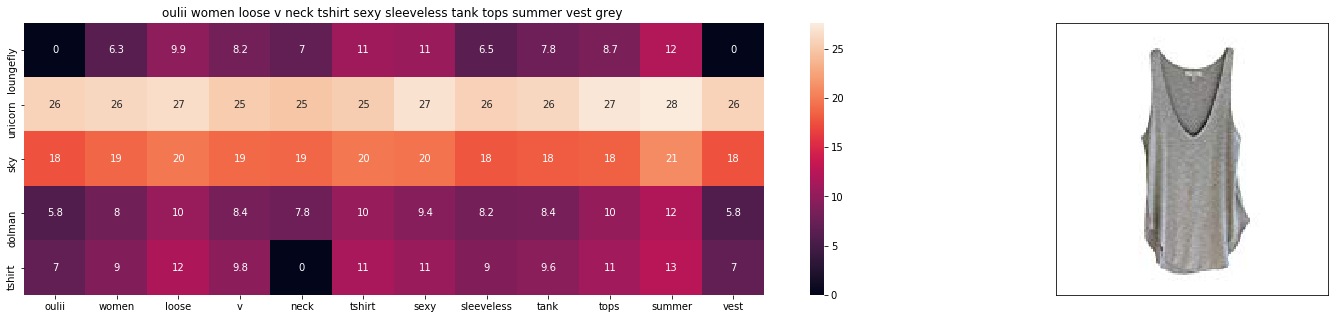

ASIN : B072KH8HBJ
Brand : OULII
euclidean distance from input : 21.830679703120165


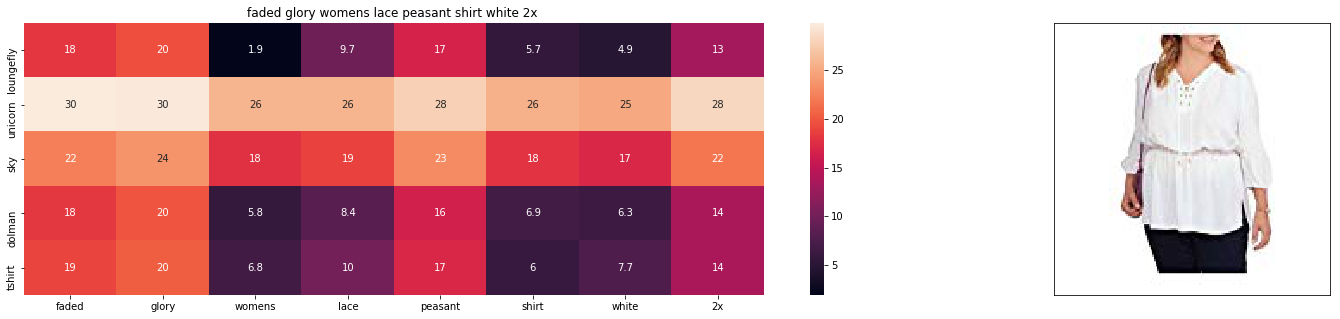

ASIN : B01MR26MXN
Brand : Faded Glory
euclidean distance from input : 21.86107455024466


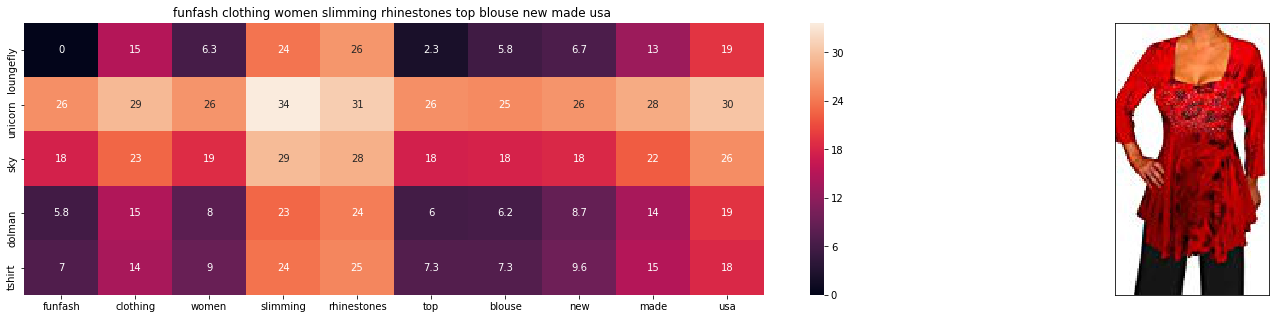

ASIN : B00C4V0K3K
Brand : Funfash
euclidean distance from input : 21.906309128168992


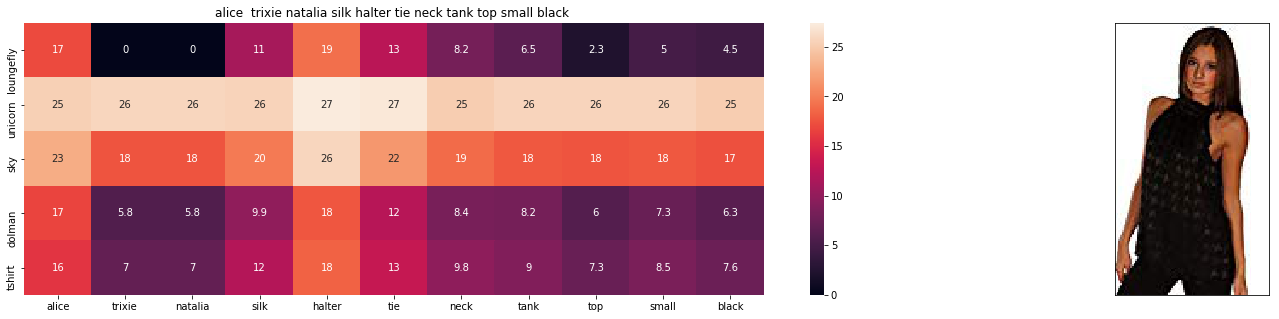

ASIN : B01D7T4BIC
Brand : Alice & Trixie
euclidean distance from input : 21.922410686108915


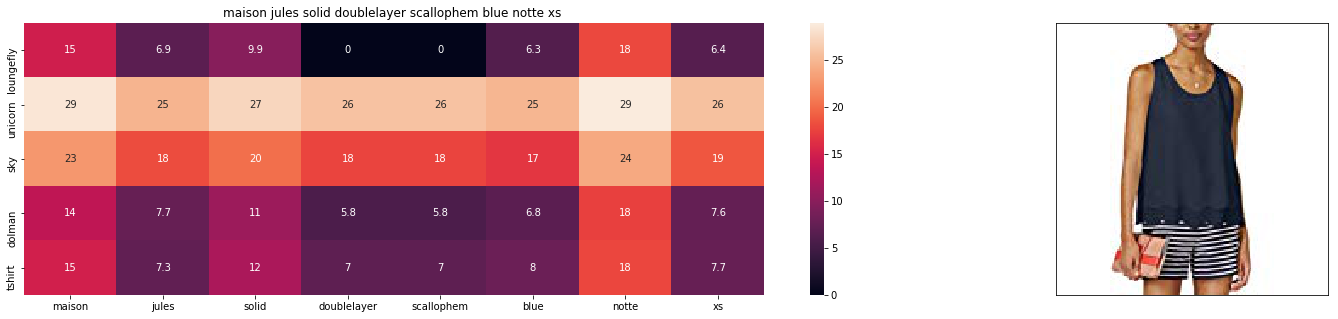

ASIN : B06XT99Y59
Brand : Maison Jules
euclidean distance from input : 21.944831569287626


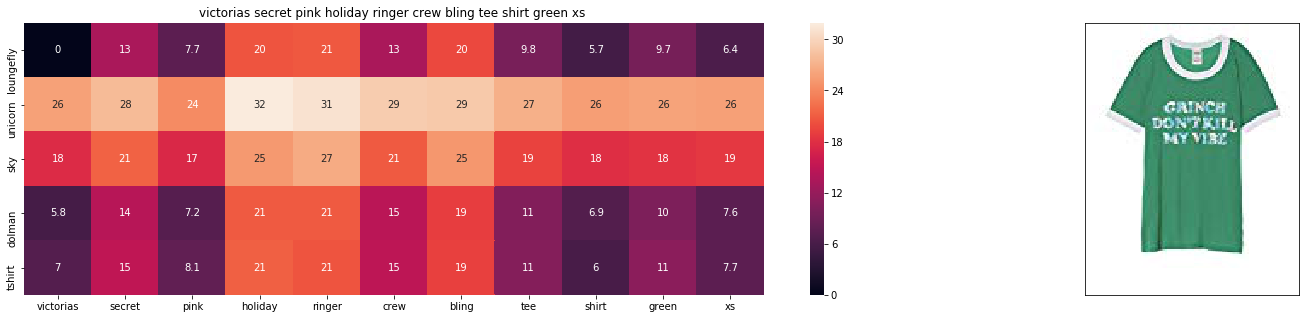

ASIN : B01MSA3SB8
Brand : Victoria's Secret
euclidean distance from input : 22.0332287860845


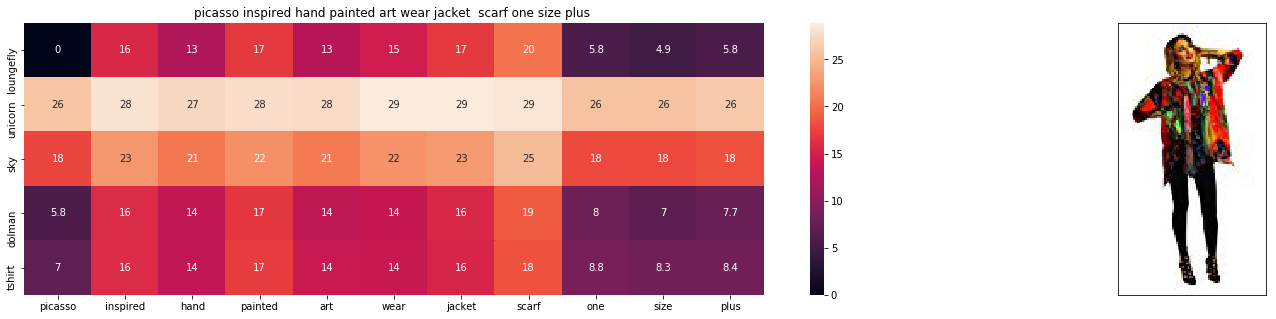

ASIN : B01M0GUXMQ
Brand : Dilemma
euclidean distance from input : 22.046984863642628


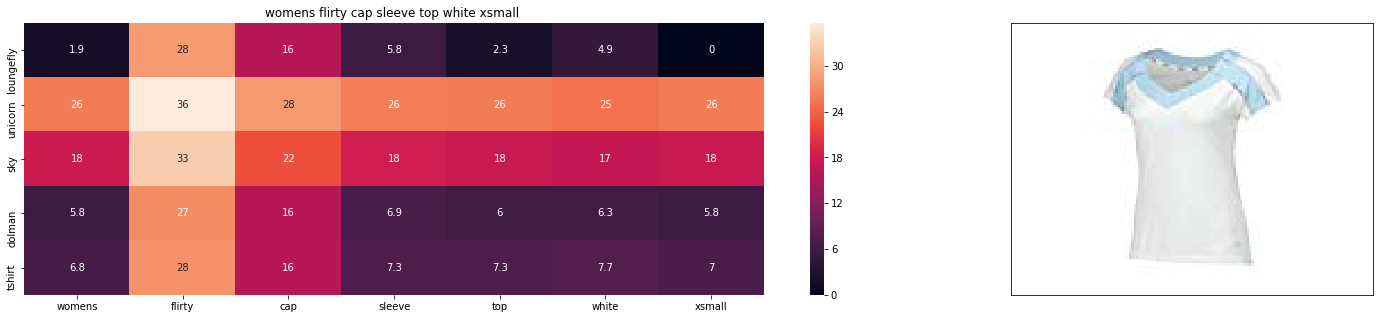

ASIN : B00U7PRVEG
Brand : Wilson
euclidean distance from input : 22.106185913447312


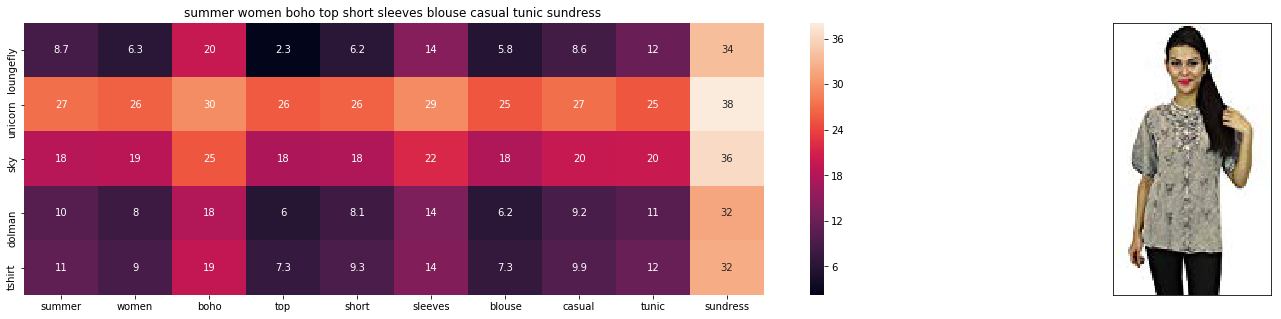

ASIN : B01NHEUGXE
Brand : Ibaexports
euclidean distance from input : 22.11132202184575


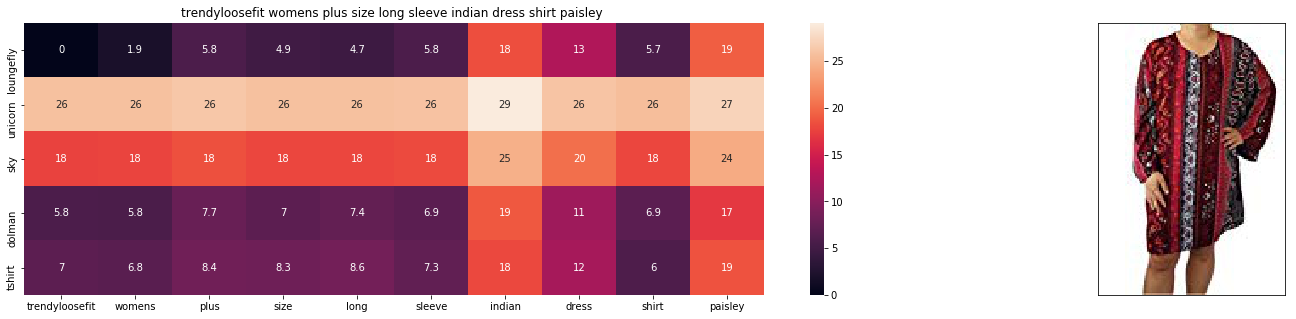

ASIN : B019RX91LY
Brand : Trendyloosefit
euclidean distance from input : 22.170517731074266


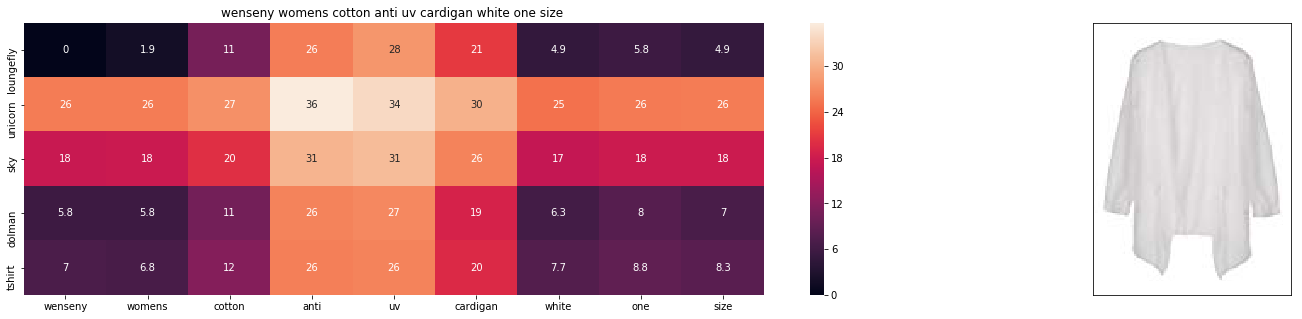

ASIN : B015E0345I
Brand : Wenseny
euclidean distance from input : 22.17910003698247


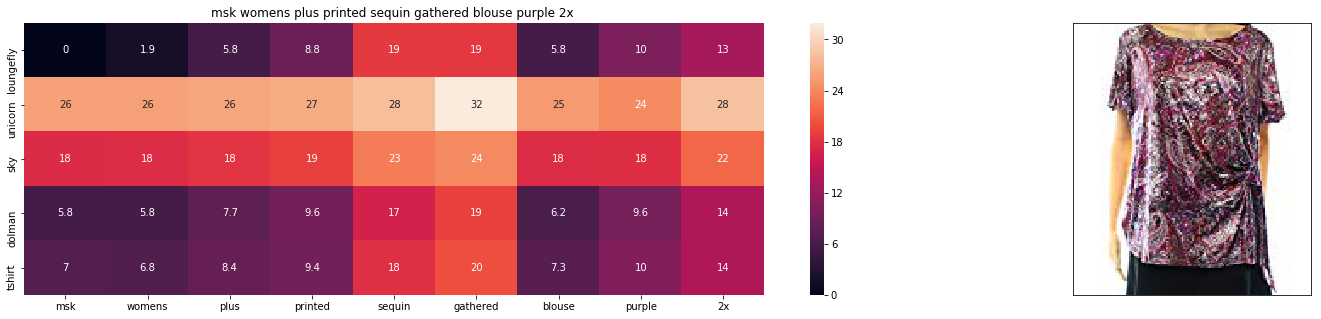

ASIN : B07229JP6M
Brand : MSK
euclidean distance from input : 22.18652191198247


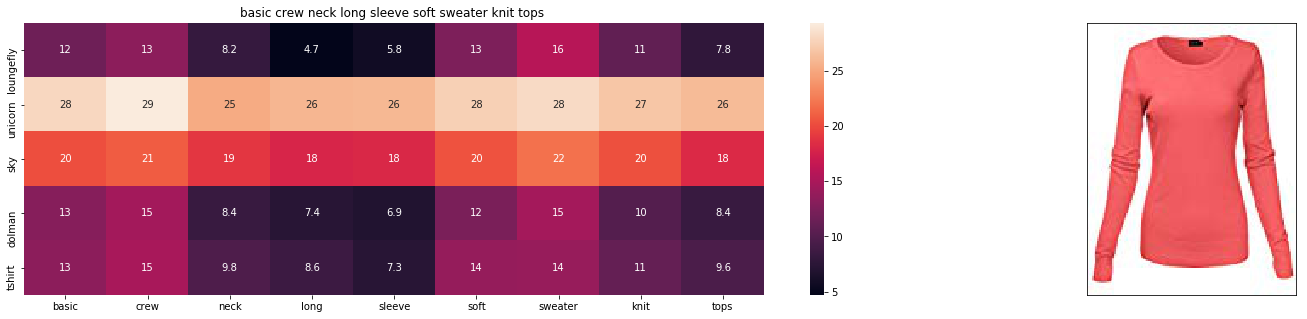

ASIN : B01MG94GU9
Brand : Luna Flower
euclidean distance from input : 22.19391985664114


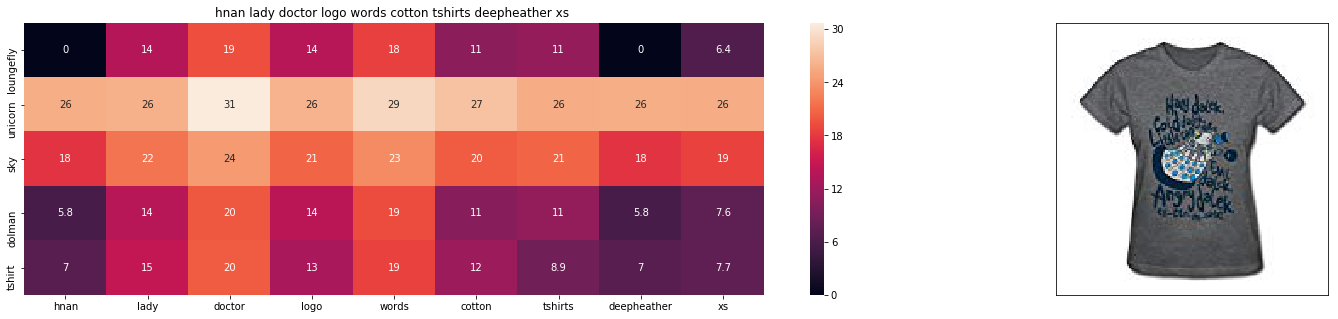

ASIN : B0142LT93Q
Brand : H'nan
euclidean distance from input : 22.21839447057622


In [37]:
idf_w2v_brand(1269, 5, 5, 5, 5, 20)

In [38]:
##here-> lesser weights=> larger similar =>higher prefernce
## bow,tf-idf,avg w2v, tfidf w2v, weighted-brand color
##industry combines all results[business rules- eg. don't show if same brand more then twice]
##A/B testing (live testing, bucket testing)